In [1]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-cartpole-embed/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, arrange_data, get_field
from nn_models import MLP, PSD
from hnn import HNN_structure_cart_embed
from utils import L2_loss, from_pickle
import imageio


In [2]:
DPI = 300
FORMAT = 'png'
LINE_WIDTH = 2

def get_args():
    return {'num_angle': 1,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'name': 'pend',
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 5,
         'gpu': 0,
         'solver': 'dopri5'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())


 ## Load models

In [3]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
def get_model(args, baseline, structure, naive, damping, num_points):
    M_net = PSD(3, 400, 2).to(device)
    g_net = MLP(3, 300, 2).to(device)
    if structure == False:
        if naive and baseline:
            raise RuntimeError('argument *baseline* and *naive* cannot both be true')
        elif naive:
            input_dim = 6
            output_dim = 5
            nn_model = MLP(input_dim, 1000, output_dim, args.nonlinearity).to(device)
            model = HNN_structure_cart_embed(args.num_angle, H_net=nn_model, device=device, baseline=baseline, naive=naive)
        elif baseline:
            input_dim = 6
            output_dim = 4
            nn_model = MLP(input_dim, 700, output_dim, args.nonlinearity).to(device)
            model = HNN_structure_cart_embed(args.num_angle, H_net=nn_model, M_net=M_net, device=device, baseline=baseline, naive=naive)
        else:
            input_dim = 5
            output_dim = 1
            nn_model = MLP(input_dim, 500, output_dim, args.nonlinearity).to(device)
            model = HNN_structure_cart_embed(args.num_angle, H_net=nn_model, M_net=M_net, g_net=g_net, device=device, baseline=baseline, naive=naive)
    elif structure == True and baseline ==False and naive==False:
        V_net = MLP(3, 300, 1).to(device)
        model = HNN_structure_cart_embed(args.num_angle, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=baseline, structure=True).to(device)
    else:
        raise RuntimeError('argument *structure* is set to true, no *baseline* or *naive*!')

    if naive:
        label = '-naive_ode'
    elif baseline:
        label = '-baseline_ode'
    else:
        label = '-hnn_ode'
    struct = '-struct' if structure else ''
    path = '{}/{}{}{}-{}-p{}.tar'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/{}{}{}-{}-p{}-stats.pkl'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    stats = from_pickle(path)
    return model, stats

naive_ode_model, naive_ode_stats = get_model(args, baseline=False, structure=False, naive=True, damping=False, num_points=args.num_points)
base_ode_model, base_ode_stats = get_model(args, baseline=True, structure=False, naive=False, damping=False, num_points=args.num_points)
hnn_ode_model, hnn_ode_stats = get_model(args, baseline=False, structure=False, naive=False, damping=False, num_points=args.num_points)
hnn_ode_struct_model, hnn_ode_struct_stats = get_model(args, baseline=False, structure=True, naive=False, damping=False, num_points=args.num_points)


 ## Final training loss

In [4]:
def get_model_parm_nums(model):
    total = sum([param.nelement() for param in model.parameters()])
    return total

print('Naive Baseline contains {} parameters'.format(get_model_parm_nums(naive_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(naive_ode_stats['traj_train_loss']), np.std(naive_ode_stats['traj_train_loss']),
        np.mean(naive_ode_stats['traj_test_loss']), np.std(naive_ode_stats['traj_test_loss'])))
print('')
print('Geometric Baseline contains {} parameters'.format(get_model_parm_nums(base_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(base_ode_stats['traj_train_loss']), np.std(base_ode_stats['traj_train_loss']),
        np.mean(base_ode_stats['traj_test_loss']), np.std(base_ode_stats['traj_test_loss'])))
print('')
print('Unstructured SymODEN contains {} parameters'.format(get_model_parm_nums(hnn_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(hnn_ode_stats['traj_train_loss']), np.std(hnn_ode_stats['traj_train_loss']),
        np.mean(hnn_ode_stats['traj_test_loss']), np.std(hnn_ode_stats['traj_test_loss'])))
print('')
print('SymODEN contains {} parameters'.format(get_model_parm_nums(hnn_ode_struct_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(hnn_ode_struct_stats['traj_train_loss']), np.std(hnn_ode_struct_stats['traj_train_loss']),
        np.mean(hnn_ode_struct_stats['traj_test_loss']), np.std(hnn_ode_struct_stats['traj_test_loss'])))


Naive Baseline contains 1013005 parameters
Final trajectory train loss 2.8459e-01 +/- 2.0169e-01
Final trajectory test loss 2.8424e-01 +/- 2.1224e-01

Geometric Baseline contains 822007 parameters
Final trajectory train loss 1.0998e-01 +/- 5.1092e-02
Final trajectory test loss 1.1348e-01 +/- 5.2950e-02

Unstructured SymODEN contains 669706 parameters
Final trajectory train loss 3.4153e-01 +/- 1.4558e-01
Final trajectory test loss 3.3545e-01 +/- 1.5311e-01

SymODEN contains 507506 parameters
Final trajectory train loss 2.0006e-01 +/- 9.1599e-02
Final trajectory test loss 1.9144e-01 +/- 9.3790e-02


 ## Dataset to get prediction error

In [5]:
us = [0.0]
data = get_dataset(seed=args.seed, timesteps=40,
            save_dir=args.save_dir, us=us, samples=64) #us=np.linspace(-2.0, 2.0, 20)

pred_x, pred_t_eval = data['x'], data['t']


Had a problem loading data from ././experiment-cartpole-embed//cartpole-gym-dataset.pkl. Rebuilding dataset...


In [6]:
from torchdiffeq import odeint
def get_pred_loss(pred_x, pred_t_eval, model):
    pred_x = torch.tensor(pred_x, requires_grad=True, dtype=torch.float32).to(device) 
    pred_t_eval = torch.tensor(pred_t_eval, requires_grad=True, dtype=torch.float32).to(device)

    pred_loss = []
    for i in range(pred_x.shape[0]):
        pred_x_hat = odeint(model, pred_x[i, 0, :, :], pred_t_eval, method='rk4')            
        pred_loss.append((pred_x[i,:,:,:] - pred_x_hat)**2)
    
    pred_loss = torch.cat(pred_loss, dim=1)
    pred_loss_per_traj = torch.sum(pred_loss, dim=(0, 2))

    return pred_loss_per_traj.detach().cpu().numpy()

naive_pred_loss = get_pred_loss(pred_x, pred_t_eval, naive_ode_model)
base_pred_loss = get_pred_loss(pred_x, pred_t_eval, base_ode_model)
hnn_pred_loss = get_pred_loss(pred_x, pred_t_eval, hnn_ode_model)
hnn_struct_pred_loss = get_pred_loss(pred_x, pred_t_eval, hnn_ode_struct_model)



In [7]:
print('Naive Baseline')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(naive_pred_loss), np.std(naive_pred_loss)))
print('')
print('Geometric Baseline')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(base_pred_loss), np.std(base_pred_loss)))
print('')
print('Unstructured SymODEN')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(hnn_pred_loss), np.std(hnn_pred_loss)))
print('')
print('SymODEN')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(hnn_struct_pred_loss), np.std(hnn_struct_pred_loss)))


Naive Baseline
Prediction error 3.7318e+01 +/- 3.9275e+01

Geometric Baseline
Prediction error 1.0541e+01 +/- 1.0283e+01

Unstructured SymODEN
Prediction error 1.3203e+02 +/- 1.1087e+02

SymODEN
Prediction error 4.1634e+00 +/- 2.8484e+00


 ## Integrate to get trajectories

In [8]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,6).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

# time info for simualtion
time_step = 100 ; n_eval = 100
t_span = [0,time_step*0.02]
t_linspace_true = np.linspace(t_span[0], time_step, time_step)*0.02
t_linspace_model = np.linspace(t_span[0], t_span[1], n_eval)

# initial condition
q0 = 1.00
x0 = 1.0
u0 = 0.0

y0_u = np.asarray([x0, np.cos(q0), np.sin(q0), 0.0, 0.0, u0])

kwargs = {'t_eval': t_linspace_model, 'rtol': 1e-12, 'method': 'RK45'}

base_ivp = integrate_model(base_ode_model, t_span, y0_u, **kwargs)
hnn_ivp = integrate_model(hnn_ode_model, t_span, y0_u, **kwargs)
hnn_struct_ivp = integrate_model(hnn_ode_struct_model, t_span, y0_u, **kwargs)

import gym 
import myenv
env = gym.make('MyCartPole-v0')
env.reset()
env.state = np.array([x0, 0.0, q0, 0.0], dtype=np.float32)
obs = env._get_obs()
obs_list = []

for _ in range(time_step):
    obs_list.append(obs)
    obs, _, _, _ = env.step([u0])

true_ivp = np.stack(obs_list, 1)
true_ivp = np.concatenate((true_ivp, u0 * np.zeros((1, time_step))), axis=0)


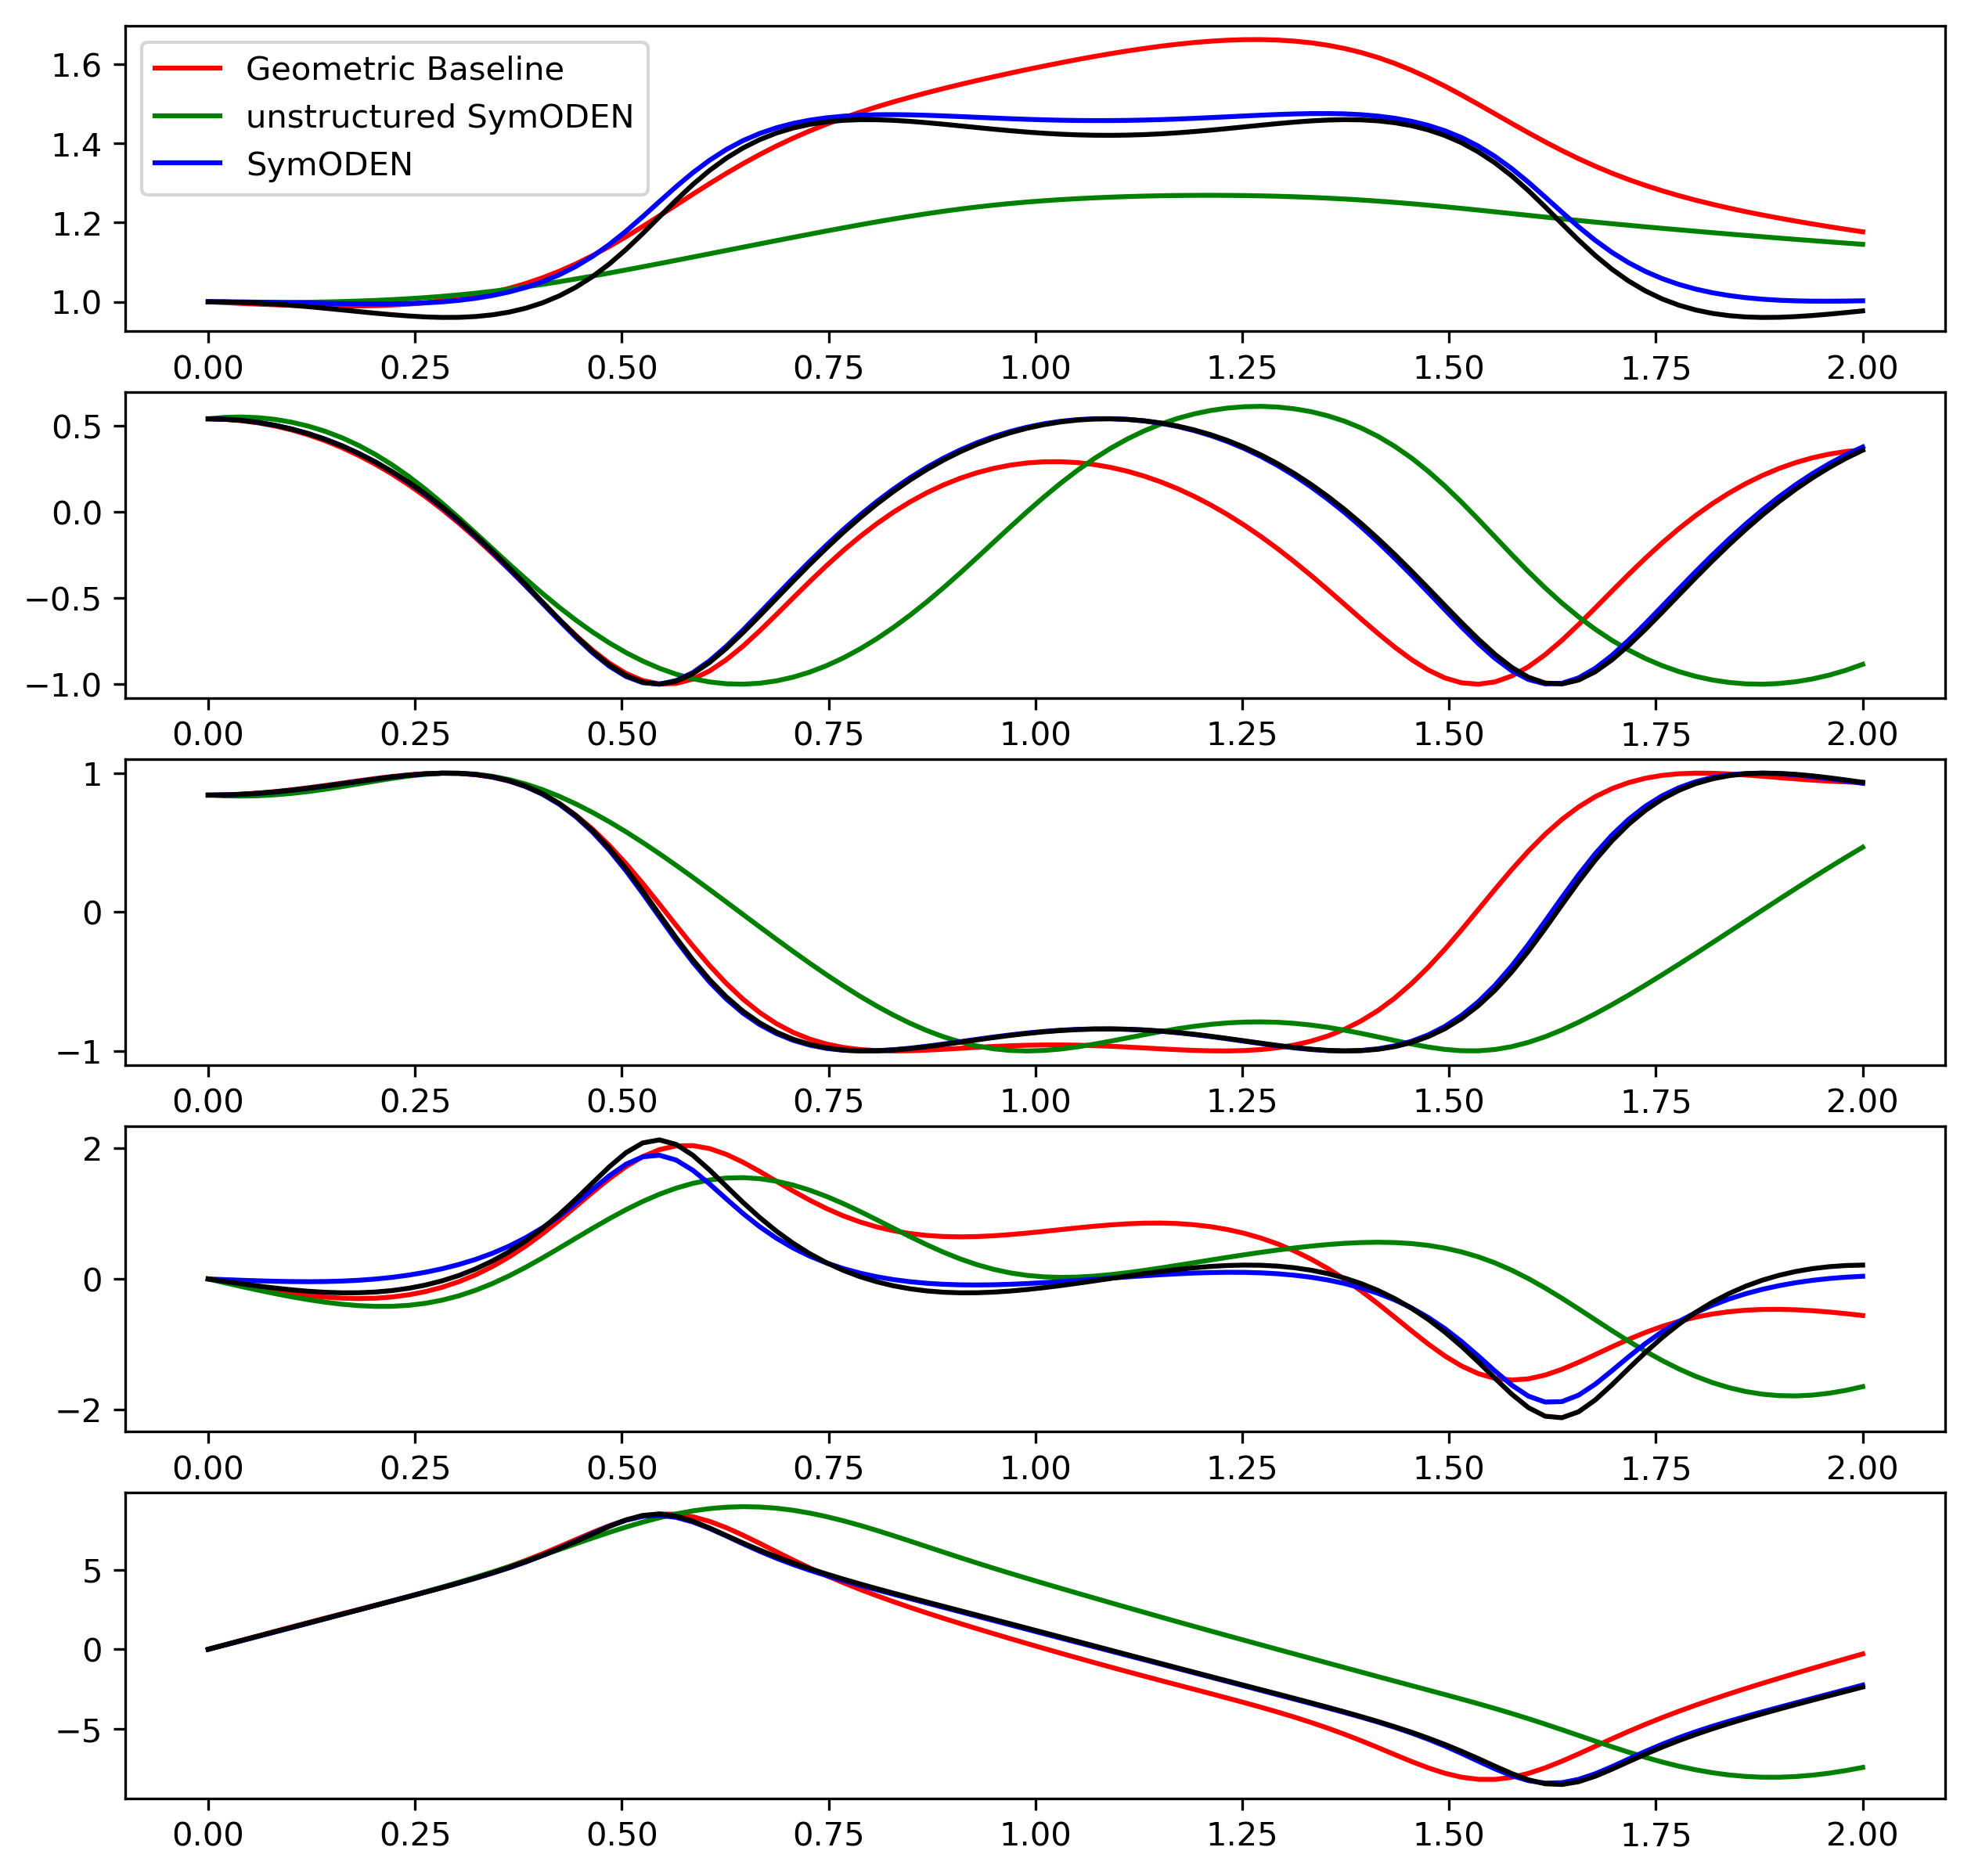

In [9]:
# comparing true trajectory and the estimated trajectory
for _ in range(1):
    fig = plt.figure(figsize=(10, 10), dpi=DPI)
    plt.subplot(5, 1, 1)
    plt.plot(t_linspace_model, base_ivp.y[0,:], 'r', label='Geometric Baseline')
    plt.plot(t_linspace_model, hnn_ivp.y[0,:], 'g', label='unstructured SymODEN')
    plt.plot(t_linspace_model, hnn_struct_ivp.y[0,:], 'b', label='SymODEN')
    plt.plot(t_linspace_true, true_ivp[0,:], 'k')
    plt.legend(fontsize=10)

    plt.subplot(5, 1, 2)
    plt.plot(t_linspace_model, base_ivp.y[1,:], 'r', label='Geometric Baseline')
    plt.plot(t_linspace_model, hnn_ivp.y[1,:], 'g', label='unstructured SymODEN')
    plt.plot(t_linspace_model, hnn_struct_ivp.y[1,:], 'b', label='SymODEN')
    plt.plot(t_linspace_true, true_ivp[1,:], 'k')

    plt.subplot(5, 1, 3)
    plt.plot(t_linspace_model, base_ivp.y[2,:], 'r', label='Geometric Baseline')
    plt.plot(t_linspace_model, hnn_ivp.y[2,:], 'g', label='unstructured SymODEN')
    plt.plot(t_linspace_model, hnn_struct_ivp.y[2,:], 'b', label='SymODEN')
    plt.plot(t_linspace_true, true_ivp[2,:], 'k')

    plt.subplot(5, 1, 4)
    plt.plot(t_linspace_model, base_ivp.y[3,:], 'r', label='Geometric Baseline')
    plt.plot(t_linspace_model, hnn_ivp.y[3,:], 'g', label='unstructured SymODEN')
    plt.plot(t_linspace_model, hnn_struct_ivp.y[3,:], 'b', label='SymODEN')
    plt.plot(t_linspace_true, true_ivp[3,:], 'k')

    plt.subplot(5, 1, 5)
    plt.plot(t_linspace_model, base_ivp.y[4,:], 'r', label='Geometric Baseline')
    plt.plot(t_linspace_model, hnn_ivp.y[4,:], 'g', label='unstructured SymODEN')
    plt.plot(t_linspace_model, hnn_struct_ivp.y[4,:], 'b', label='SymODEN')
    plt.plot(t_linspace_true, true_ivp[4,:], 'k')


 ## A simple PD controller
 The following code saves the rendering as a mp4 video and as a GIF at the same time

In [10]:
# time info for simualtion
time_step = 400 ; n_eval = 400
t_span = [0,time_step*0.02]
t_linspace_true = np.linspace(t_span[0], time_step, time_step)*0.02
t_linspace_model = np.linspace(t_span[0], t_span[1], n_eval)
# angle info for simuation
q0 = 0.2
x0 = 0.0
u0 = 0.0

# record video
from gym import wrappers
env = gym.make('MyCartPole-v0')
env = gym.wrappers.Monitor(env, './videos/' + 'cartpole-embed' + '/', force=True) # , video_callable=lambda x: True, force=True

env.reset()
env.env.state = np.array([x0, 0.0, q0, 0.0], dtype=np.float32)
obs = env.env._get_obs()
y = torch.tensor([obs[0], obs[1], obs[2], obs[3], obs[4], u0], requires_grad=True, device=device, dtype=torch.float32).view(1, 6)

t_eval = torch.linspace(t_span[0], t_span[1], n_eval).to(device)

y_traj = []
y_traj.append(y)
frames = []
for i in range(len(t_eval)-1):
    frames.append(env.render(mode='rgb_array'))

    x_cos_q_sin_q, x_dot_q_dot, u = torch.split(y, [3, 2, 1], dim=1)
    M_q_inv = hnn_ode_struct_model.M_net(x_cos_q_sin_q)
    x_dot_q_dot_aug = torch.unsqueeze(x_dot_q_dot, dim=2)
    p = torch.squeeze(torch.matmul(torch.inverse(M_q_inv), x_dot_q_dot_aug), dim=2)
    x_cos_q_sin_q_p = torch.cat((x_cos_q_sin_q, p), dim=1)
    x_cos_q_sin_q, p = torch.split(x_cos_q_sin_q_p, [3, 2], dim=1)
    M_q_inv = hnn_ode_struct_model.M_net(x_cos_q_sin_q)
    _, cos_q, sin_q = torch.chunk(x_cos_q_sin_q, 3,dim=1)
    V_q = hnn_ode_struct_model.V_net(x_cos_q_sin_q)   
    p_aug = torch.unsqueeze(p, dim=2)
    H = torch.squeeze(torch.matmul(torch.transpose(p_aug, 1, 2), torch.matmul(M_q_inv, p_aug)))/2.0 + torch.squeeze(V_q)
    dH = torch.autograd.grad(H.sum(), x_cos_q_sin_q_p, create_graph=True)[0]
    dHdx, dHdcos_q, dHdsin_q, dHdp= torch.split(dH, [1, 1, 1, 2], dim=1)
    dV = torch.autograd.grad(V_q, x_cos_q_sin_q)[0]
    dVdx, dVdcos_q, dVdsin_q= torch.chunk(dV, 3, dim=1)
    dV_q = - dVdcos_q * sin_q + dVdsin_q * cos_q
    g_xq = hnn_ode_struct_model.g_net(x_cos_q_sin_q)
    g_norm = torch.sum(g_xq * g_xq, dim=1)

    k_p = 100.0 ; k_d = 2.0
    u = 70 * sin_q + 0.9 * x_dot_q_dot[:, 1]

    u = u.detach().cpu().numpy()
    obs, _, _, _ = env.step(u)
    y = torch.tensor([obs[0], obs[1], obs[2], obs[3], obs[4], u], requires_grad=True, device=device, dtype=torch.float32).view(1, 6)

    y_traj.append(y)
env.close()
imageio.mimsave('./videos/cartpole-embed/cartpole-embed.gif', frames, duration=0.02)

y_traj = torch.stack(y_traj).view(-1, 6).detach().cpu().numpy()


 ## Plot control result

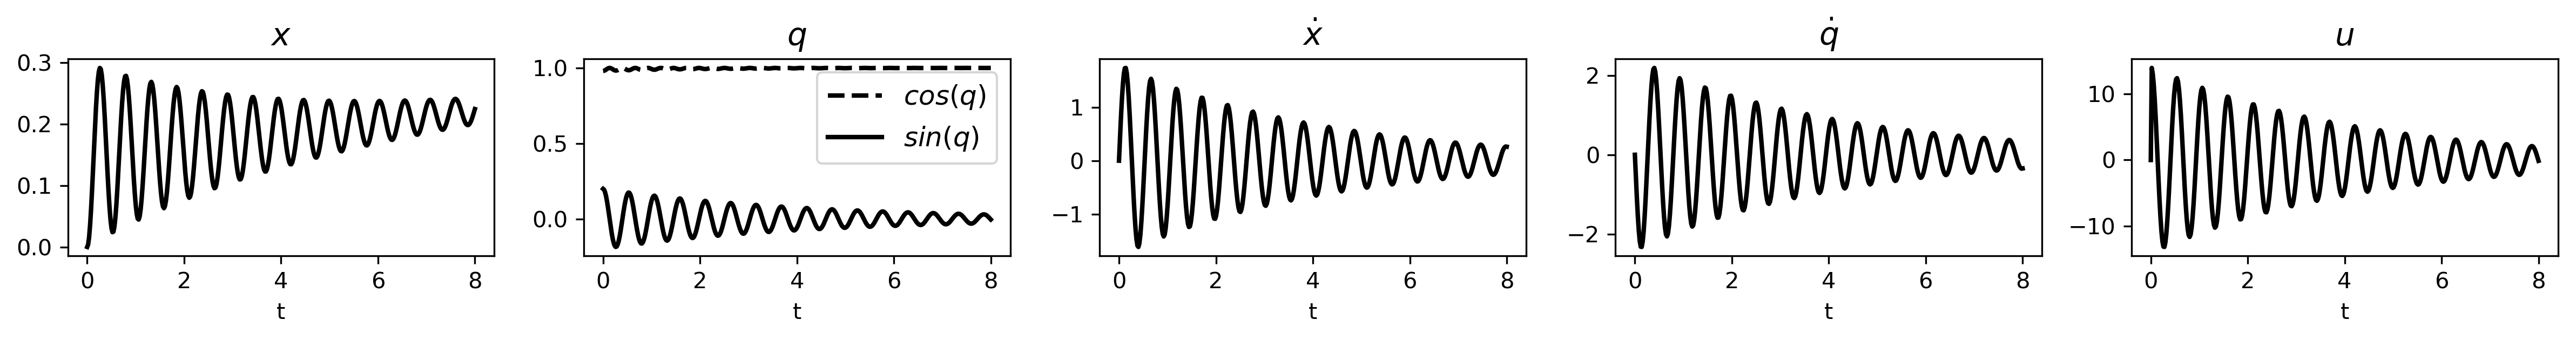

In [11]:
fig = plt.figure(figsize=[16, 2.2], dpi=DPI)
plt.subplot(1, 5, 1)
plt.plot(t_eval.numpy(), y_traj[:, 0], color='k', linewidth=LINE_WIDTH)
plt.title("$x$", fontsize=14)
plt.xlabel('t')

plt.subplot(1, 5, 2)
plt.plot(t_eval.numpy(), y_traj[:, 1], 'k--', label="$cos(q)$", linewidth=LINE_WIDTH)
plt.plot(t_eval.numpy(), y_traj[:, 2], 'k-', label="$sin(q)$", linewidth=LINE_WIDTH)
plt.title("$q$", fontsize=14)
plt.xlabel('t')
plt.legend(fontsize=12)

plt.subplot(1, 5, 3)
plt.plot(t_eval.numpy(), y_traj[:, 3], color='k', linewidth=LINE_WIDTH)
plt.title("$\dot{x}$", fontsize=14)
plt.xlabel('t')

plt.subplot(1, 5, 4)
plt.plot(t_eval.numpy(), y_traj[:, 4], color='k', linewidth=LINE_WIDTH)
plt.title("$\dot{q}$", fontsize=14)
plt.xlabel('t')

plt.subplot(1, 5, 5)
plt.plot(t_eval.numpy(), y_traj[:, 5], color='k', linewidth=LINE_WIDTH)
plt.title("$u$", fontsize=14)
plt.xlabel('t')

plt.tight_layout()
# fig.savefig('{}/fig-cartpole-ctrl.{}'.format(args.fig_dir, FORMAT))

